In [46]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import collections

from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Proposed Model

In [11]:
PATH = '../results/proposed-model/metrics/'

In [12]:
maxiter = 11
output = {}
for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
    for embedding in ['word2vec', 'fasttext','concat']:
        for it in range(1, maxiter):
            out = pd.read_pickle(PATH+f'GRU-256-{embedding}-{task}-{it}-new-cnn-.p')
            output[task+'-'+embedding+'-'+str(it)] = out

In [13]:
out_df = pd.DataFrame(output).transpose().reset_index()

In [14]:
out_df['task'] = out_df['index'].str.split('-', expand=True)[0]
out_df['embedding'] = out_df['index'].str.split('-', expand=True)[1]
out_df['iter'] = out_df['index'].str.split('-', expand=True)[2]

In [15]:
display(out_df)

,index,auc,auprc,acc,F1,task,embedding,iter
0,los_3-word2vec-1,0.699583,0.640729,0.663414,0.544952,los_3,word2vec,1
1,los_3-word2vec-2,0.700040,0.641611,0.665683,0.567147,los_3,word2vec,2
2,los_3-word2vec-3,0.705171,0.647851,0.668634,0.559445,los_3,word2vec,3
3,los_3-word2vec-4,0.702934,0.644672,0.655243,0.487690,los_3,word2vec,4
4,los_3-word2vec-5,0.691195,0.633026,0.659101,0.542909,los_3,word2vec,5
...,...,...,...,...,...,...,...,...
115,mort_icu-concat-6,0.881870,0.514552,0.940763,0.450526,mort_icu,concat,6
116,mort_icu-concat-7,0.886337,0.535997,0.942805,0.456897,mort_icu,concat,7
117,mort_icu-concat-8,0.879854,0.517409,0.938039,0.489720,mort_icu,concat,8
118,mort_icu-concat-9,0.880359,0.516834,0.941670,0.400932,mort_icu,concat,9


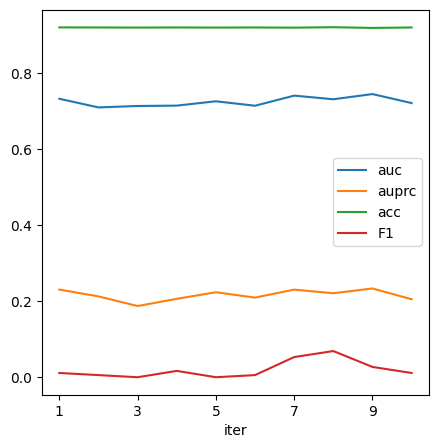

In [16]:
out_df[(out_df['task']=='los_7') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

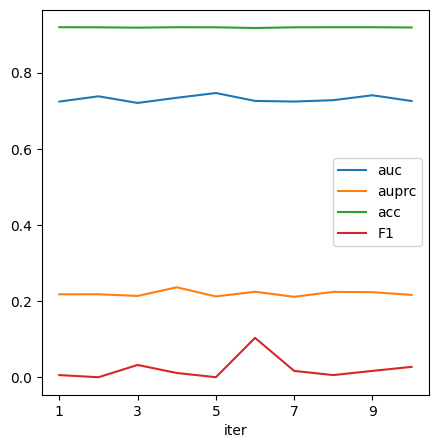

In [17]:
out_df[(out_df['task']=='los_7') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

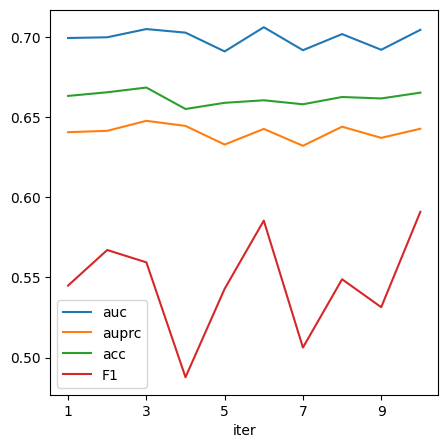

In [18]:
out_df[(out_df['task']=='los_3') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

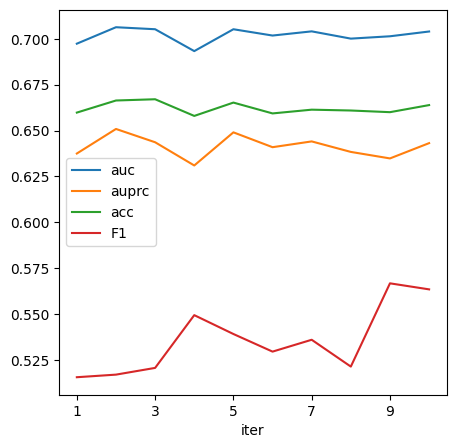

In [19]:
out_df[(out_df['task']=='los_3') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

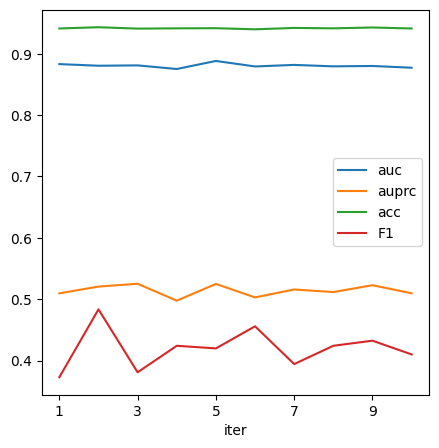

In [20]:
out_df[(out_df['task']=='mort_icu') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

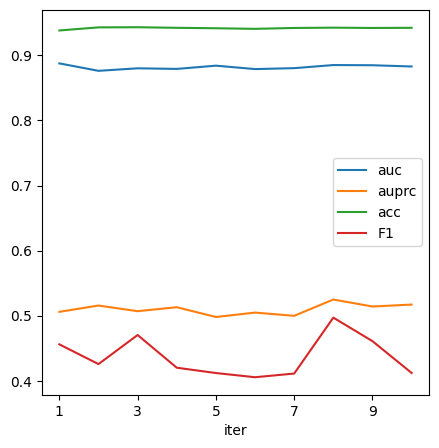

In [21]:
out_df[(out_df['task']=='mort_icu') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

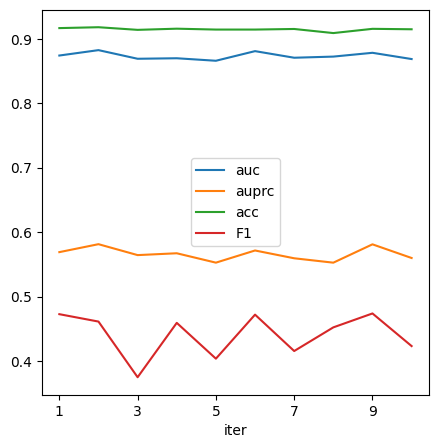

In [22]:
out_df[(out_df['task']=='mort_hosp') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

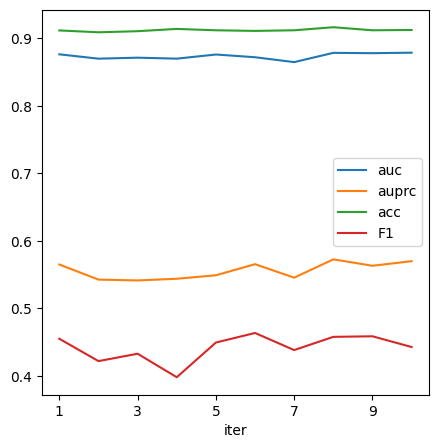

In [23]:
out_df[(out_df['task']=='mort_hosp') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

In [25]:
max_score = {}
for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
    for embedding in ['word2vec','fasttext','concat']:
        ind = out_df[(out_df['task']==task) & (out_df['embedding']==embedding)]['auc'].argmax()
        score = out_df[(out_df['task']==task) & (out_df['embedding']==embedding)].iloc[ind][['auc', 'auprc', 'acc', 'F1']].to_dict()
        max_score[task+'-'+embedding] = score

In [26]:
pd.DataFrame(max_score).transpose()

,auc,auprc,acc,F1
los_3-word2vec,0.706321,0.642793,0.660690,0.585528
los_3-fasttext,0.706271,0.650867,0.666364,0.517083
los_3-concat,0.709983,0.650439,0.661825,0.586800
los_7-word2vec,0.744368,0.233339,0.918293,0.027027
los_7-fasttext,0.746599,0.212171,0.919201,0.000000
los_7-concat,0.738795,0.223097,0.919428,0.005602
mort_hosp-word2vec,0.882303,0.581340,0.917839,0.461310
mort_hosp-fasttext,0.878971,0.570017,0.912619,0.442836
mort_hosp-concat,0.877698,0.568823,0.913754,0.358108
mort_icu-word2vec,0.888295,0.524926,0.941670,0.419865


In [27]:
pd.DataFrame(max_score).transpose().to_csv('../results/proposed-model/metrics/best_scores.csv')

# Baseline

In [28]:
PATH = '../results/timeseries-baseline/metrics/'

In [29]:
maxiter = 11
output = {}
for model in ['GRU', 'LSTM']:
    for size in [128, 256]:
        for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
            for it in range(1, maxiter):
                out = pd.read_pickle(PATH+f'{size}-{model}-{task}-{it}-new.p')
                output['-'.join([str(size), model, task, str(it)])] = out

In [30]:
bl_outdf = pd.DataFrame(output).transpose()
bl_outdf = bl_outdf.reset_index()

In [31]:
bl_outdf['index'].str.split('-', expand=True)

,0,1,2,3
0,128,GRU,los_3,1
1,128,GRU,los_3,2
2,128,GRU,los_3,3
3,128,GRU,los_3,4
4,128,GRU,los_3,5
...,...,...,...,...
155,256,LSTM,mort_icu,6
156,256,LSTM,mort_icu,7
157,256,LSTM,mort_icu,8
158,256,LSTM,mort_icu,9


In [32]:
bl_outdf['hidden_unit'] = bl_outdf['index'].str.split('-', expand=True)[0]
bl_outdf['model'] = bl_outdf['index'].str.split('-',  expand=True)[1]
bl_outdf['task'] = bl_outdf['index'].str.split('-',  expand=True)[2]
bl_outdf['iter'] = bl_outdf['index'].str.split('-',  expand=True)[3]

In [33]:
print(bl_outdf)

                    index       auc     auprc       acc        F1 hidden_unit  \
0         128-GRU-los_3-1  0.692213  0.641977  0.661825  0.554159         128   
1         128-GRU-los_3-2  0.694263  0.637183  0.662279  0.551807         128   
2         128-GRU-los_3-3  0.687500  0.629461  0.657512  0.570453         128   
3         128-GRU-los_3-4  0.690616  0.631797  0.657286  0.545728         128   
4         128-GRU-los_3-5  0.701538  0.642738  0.666364  0.562760         128   
..                    ...       ...       ...       ...       ...         ...   
155   256-LSTM-mort_icu-6  0.879490  0.465627  0.935089  0.347032         256   
156   256-LSTM-mort_icu-7  0.882524  0.508054  0.941217  0.423163         256   
157   256-LSTM-mort_icu-8  0.887754  0.504423  0.940309  0.378251         256   
158   256-LSTM-mort_icu-9  0.880689  0.502082  0.940763  0.410835         256   
159  256-LSTM-mort_icu-10  0.879466  0.484076  0.938039  0.357647         256   

    model      task iter  


In [34]:
bl_score = {}
for model in ['GRU', 'LSTM']:
        for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
            sub_df = bl_outdf[(bl_outdf['model']==model) & (bl_outdf['task']==task)]
            ind = sub_df['auc'].argmax()
            bl_score['-'.join([model, task])] = sub_df.iloc[ind]

In [35]:
ts_baseline_df = pd.DataFrame(bl_score).transpose().sort_values('task')

In [36]:
ts_baseline_df.to_csv('../results/timeseries-baseline/metrics/best_scores.csv')

In [37]:
display(ts_baseline_df)

,index,auc,auprc,acc,F1,hidden_unit,model,task,iter
GRU-los_3,128-GRU-los_3-5,0.701538,0.642738,0.666364,0.56276,128,GRU,los_3,5
LSTM-los_3,128-LSTM-los_3-4,0.696343,0.633673,0.658193,0.5369,128,LSTM,los_3,4
GRU-los_7,256-GRU-los_7-2,0.747498,0.221757,0.91852,0.047745,256,GRU,los_7,2
LSTM-los_7,256-LSTM-los_7-8,0.739706,0.204073,0.918747,0.01105,256,LSTM,los_7,8
GRU-mort_hosp,256-GRU-mort_hosp-9,0.884279,0.564403,0.912846,0.440233,256,GRU,mort_hosp,9
LSTM-mort_hosp,256-LSTM-mort_hosp-8,0.879725,0.558737,0.916931,0.45045,256,LSTM,mort_hosp,8
GRU-mort_icu,128-GRU-mort_icu-8,0.891895,0.520284,0.940082,0.440678,128,GRU,mort_icu,8
LSTM-mort_icu,128-LSTM-mort_icu-8,0.893798,0.513111,0.941897,0.415525,128,LSTM,mort_icu,8


# Multimodal Baseline

In [47]:
PATH = '../results/multimodal-baseline/metrics/'

In [48]:
maxiter = 11
output = {}

for size in [128]:
    for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
            for embedding in ['word2vec', 'fasttext', 'concat','doc2vec']:
                out = pd.read_pickle(PATH+f'GRU-{size}-{embedding}-{task}-1-new-avg-.p')
                output['-'.join([str(size), task, embedding])] = out

In [49]:
blavg_outdf = pd.DataFrame(output).transpose()
blavg_outdf = blavg_outdf.reset_index()

In [50]:
blavg_outdf['hidden_unit'] = blavg_outdf['index'].str.split('-', expand=True)[0]
blavg_outdf['task'] = blavg_outdf['index'].str.split('-', expand=True)[1]
blavg_outdf['embedding'] = blavg_outdf['index'].str.split('-', expand=True)[2]

In [51]:
print(blavg_outdf)

                     index       auc     auprc       acc        F1  \
0       128-los_3-word2vec  0.701746  0.642210  0.659782  0.552136   
1       128-los_3-fasttext  0.705585  0.644283  0.667726  0.553386   
2         128-los_3-concat  0.710999  0.649688  0.667045  0.577112   
3        128-los_3-doc2vec  0.684934  0.624441  0.656378  0.552600   
4       128-los_7-word2vec  0.728503  0.212106  0.919428  0.016620   
5       128-los_7-fasttext  0.737881  0.229783  0.919201  0.000000   
6         128-los_7-concat  0.740868  0.211529  0.918974  0.042895   
7        128-los_7-doc2vec  0.715294  0.197631  0.918747  0.027174   
8   128-mort_hosp-word2vec  0.883033  0.594587  0.918974  0.489270   
9   128-mort_hosp-fasttext  0.883361  0.582703  0.914889  0.390244   
10    128-mort_hosp-concat  0.877172  0.570952  0.916478  0.437309   
11   128-mort_hosp-doc2vec  0.883205  0.581472  0.918747  0.479651   
12   128-mort_icu-word2vec  0.883480  0.539991  0.943032  0.389294   
13   128-mort_icu-fa

In [54]:
max_score = {}
for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
    for embedding in ['word2vec','fasttext','concat','doc2vec']:
        ind = blavg_outdf[(blavg_outdf['task']==task) & (blavg_outdf['embedding']==embedding)]['auc'].argmax()
        score = blavg_outdf[(blavg_outdf['task']==task) & (blavg_outdf['embedding']==embedding)].iloc[ind][['auc', 'auprc', 'acc', 'F1']].to_dict()
        max_score[task+'-'+embedding] = score

In [55]:
pd.DataFrame(max_score).transpose()

,auc,auprc,acc,F1
los_3-word2vec,0.701746,0.642210,0.659782,0.552136
los_3-fasttext,0.705585,0.644283,0.667726,0.553386
los_3-concat,0.710999,0.649688,0.667045,0.577112
los_3-doc2vec,0.684934,0.624441,0.656378,0.552600
los_7-word2vec,0.728503,0.212106,0.919428,0.016620
los_7-fasttext,0.737881,0.229783,0.919201,0.000000
los_7-concat,0.740868,0.211529,0.918974,0.042895
los_7-doc2vec,0.715294,0.197631,0.918747,0.027174
mort_hosp-word2vec,0.883033,0.594587,0.918974,0.489270
mort_hosp-fasttext,0.883361,0.582703,0.914889,0.390244


In [56]:
pd.DataFrame(max_score).transpose().to_csv('../results/multimodal-baseline/metrics/best_scores.csv')